In [93]:
import ujson as json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [94]:
results = 've-benchmarking/query_results/'

with open(results + "asr.json", "r") as f:
    results_asr = json.load(f)

with open(results + "caption.json", "r") as f:
    results_caption = json.load(f)

with open(results + "clip.json", "r") as f:
    results_clip = json.load(f)

with open(results + "ocr.json", "r") as f:
    results_ocr = json.load(f)

with open(results + "mix.json", "r") as f:
    results_mix = json.load(f)

In [95]:
def iou(query, candidate):
    cand_file = os.path.basename(candidate["properties"]["path"])
    if cand_file in query["files"]:
        if "start" in candidate["properties"]:
            # video
            # convert nanoseconds to seconds to match with baseline
            candidate_start = int(candidate["properties"]["start"]) / 1000000000.0
            candidate_end = int(candidate["properties"]["end"]) / 1000000000.0
            truth_start = query["segments"][0][0]
            truth_end = query["segments"][0][1]

            intersection = min(truth_end,candidate_end)-max(truth_start,candidate_start)
            if intersection < 0:
                # negative intersection = no overlap = IOU 0
                return 0.0
            
            union = (candidate_end-candidate_start) + (truth_end-truth_start) - intersection
            return intersection/union
        else:
            # image is correct
            return 1.0
    else:
        # retrievable is not in expected files
        return 0.0

In [96]:
def format_iou(query, method, rank):
    if len(query["response"]["retrievables"])>0: 
        iou_score = iou(query["query"],query["response"]["retrievables"][rank])
        return {
            "iou": iou_score,
            "rank": rank+1,
            "method": method,
            "class": " ".join(query["query"]["tag"])
        }


In [97]:
def rank(query, candidates):
    truth = query["files"]
    for i in range(len(candidates)):
        cand_file = os.path.basename(candidates[i]["properties"]["path"])
        if cand_file in truth:
            return i+1
        
    return float("inf") # not found at all

In [98]:
def format_mrr(query, method):
    if len(query["response"]["retrievables"]) > 0:
        res_rank = rank(query["query"], query["response"]["retrievables"])
    else:
        # no match retrieved at all
        res_rank = float("inf")
    return {
        "rank": res_rank,
        "mrr": 1.0/res_rank,
        "method": method,
        "class": " ".join(query["query"]["tag"])
    }

## Intersection-over-union for video retrievables, MRR for image retrievables

In [119]:
iou_results = []
mrr_results = []
for result in results_asr:
    for i in range(len(result["response"]["retrievables"])):
        iou_results.append(format_iou(result, "ASR", i))
    mrr_results.append(format_mrr(result, "ASR"))


for result in results_caption:
    for i in range(len(result["response"]["retrievables"])):
        iou_results.append(format_iou(result, "Caption", i))
    mrr_results.append(format_mrr(result, "Caption"))


for result in results_clip:
    for i in range(len(result["response"]["retrievables"])):
        iou_results.append(format_iou(result, "Clip", i))
    mrr_results.append(format_mrr(result, "Clip"))


for result in results_ocr:
    for i in range(len(result["response"]["retrievables"])):
        iou_results.append(format_iou(result, "OCR", i))
    mrr_results.append(format_mrr(result, "OCR"))


for result in results_mix:
    for i in range(len(result["response"]["retrievables"])):
        iou_results.append(format_iou(result, "Combined", i))
    mrr_results.append(format_mrr(result, "Combined"))

In [124]:
mrr_df = pd.DataFrame(mrr_results)
iou_df = pd.DataFrame(iou_results)
grouped_iou = iou_df.groupby(['method', 'rank'])['iou'].sum().reset_index()
grouped_iou['cumulative_iou'] = grouped_iou.groupby('method')['iou'].cumsum()

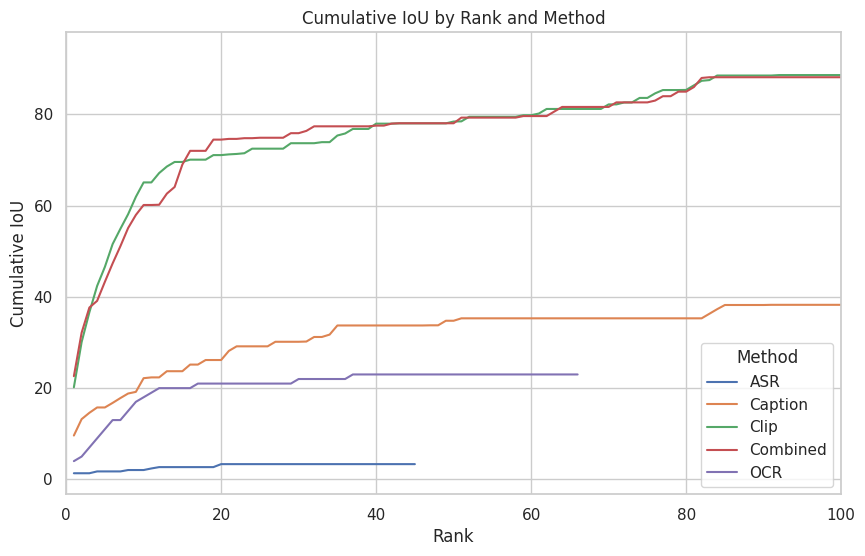

In [140]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_iou, x='rank', y='cumulative_iou', hue='method', marker=None)

# Customize the plot
plt.title('Cumulative IoU by Rank and Method')
plt.xlabel('Rank')
plt.ylabel('Cumulative IoU')
plt.legend(title='Method')
plt.grid(True)
plt.xlim(0,100)

# Show the plot
plt.show()

In [104]:
sns.reset_defaults()
cutoffs = [1,2,5,10,25,50,100,200]

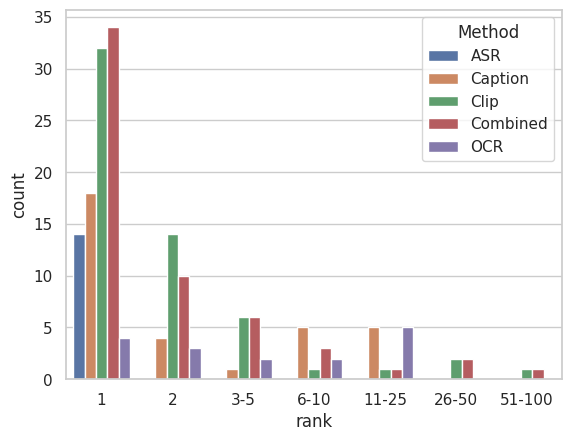

In [137]:
# Create a DataFrame with bins and counts for each method
hist_data = []
for method_group in mrr_df.groupby("method"):
    method_name, method_group = method_group
    counts, _ = np.histogram(method_group["rank"], bins=cutoffs)
    hist_data.extend({"method": method_name, "rank": bin, "count": count} for bin, count in zip(cutoffs, counts))

hist_df = pd.DataFrame(hist_data)

# Plotting side-by-side bars with the same width
sns.barplot(data=hist_df, x="rank", y="count", hue="method", dodge=True)

xticklabels = ["1", "2", "3-5", "6-10", "11-25", "26-50", "51-100"]
plt.xticks(range(len(xticklabels)), xticklabels)
#plt.yticks(range(13))

# Add legend
plt.legend(title="Method")

# Show the plot
plt.show()

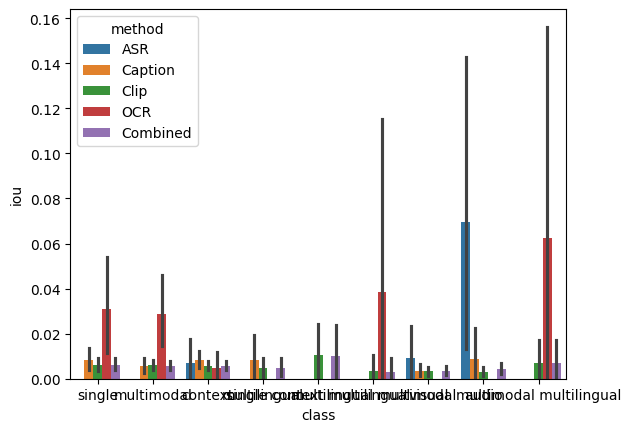

In [106]:
sns.barplot(data=iou_df, x="class", y="iou", hue="method", dodge=True)
plt.show()

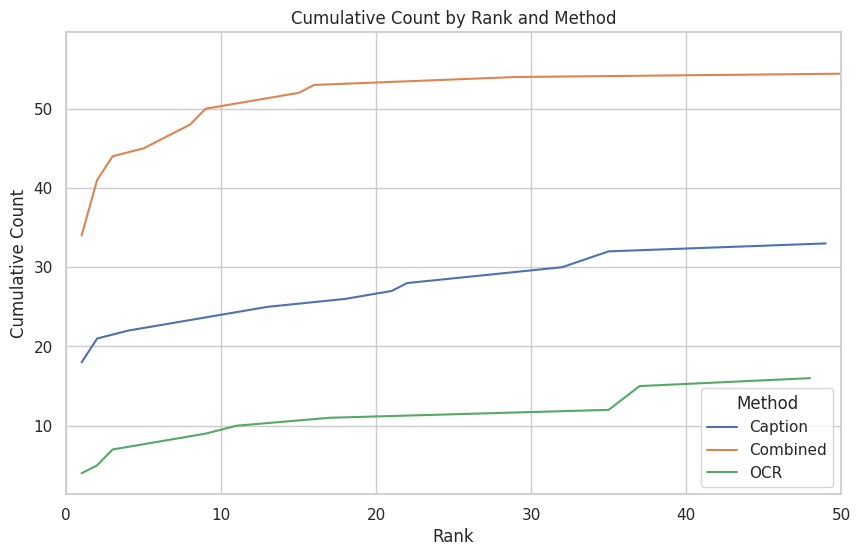

In [136]:
#mrr_df['rank'].replace(float('inf'), 251, inplace=True)

# Filter the DataFrame to include only the methods 'Caption', 'OCR', and 'Combined'
filtered_df = mrr_df[mrr_df['method'].isin(['Caption', 'OCR', 'Combined'])]

# Group by 'method' and 'rank', and count occurrences
grouped = filtered_df.groupby(['method', 'rank']).size().reset_index(name='count')

# Add cumulative count of 'rank' within each 'method'
grouped['cumulative_count'] = grouped.groupby('method')['count'].cumsum()

# Reset seaborn style to default seaborn settings
sns.reset_defaults()

# Alternatively, reset seaborn style to original matplotlib settings
# sns.reset_orig()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='rank', y='cumulative_count', hue='method', marker=None)

# Customize the plot
plt.title('Cumulative Count by Rank and Method')
plt.xlabel('Rank')
plt.ylabel('Cumulative Count')
plt.legend(title='Method')
plt.grid(True)
plt.xlim(0,50)

# Show the plot
plt.show()